In [36]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import re
import copy

def load_gridsearch_results(logs_path, pickle_filename: str = 'gridsearch_results.pkl'):
    results_path = os.path.join(logs_path, pickle_filename)
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    return results

dyn_no_dil_base_path = os.path.join('logs', 'multi_layer_dynamic_no_dilation_base')
dyn_no_dil_base = 'gridsearch_results.pkl'
dyn_no_dil_base_results = load_gridsearch_results(dyn_no_dil_base_path, dyn_no_dil_base)

static_dilated_path = os.path.join('logs', 'multi_layer_dilation_base')
static_dilated = 'gridsearch_results.pkl'
static_dilated_results = load_gridsearch_results(static_dilated_path, static_dilated)

dynamic_1l_no_layernorm_path = os.path.join('logs', 'multi_layer_dynamic_1l_no_layernorm')
dynamic_1l_no_layernorm = 'gridsearch_results.pkl'
dynamic_1l_no_layernorm_results = load_gridsearch_results(dynamic_1l_no_layernorm_path, dynamic_1l_no_layernorm)

exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm')
no_bidi = 'gridsearch_results_no_bidirectional.pkl'
no_bidi_results = load_gridsearch_results(exp_path, no_bidi)

general_single_path = os.path.join('..', '07_single_layer_rnns', 'mac_logs', 'general_rnn_gridsearch')
single_layer_results = load_gridsearch_results(general_single_path)
lstm_50 = single_layer_results[2]

dynamic_lr_exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm_dynamic_lr')
layers_2 = 'gridsearch_results_02_layers.pkl'
layers_2_results = load_gridsearch_results(dynamic_lr_exp_path, layers_2)

dynamic_lr_46_exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm_dynamic_246')
dynamic_lr_46 = 'gridsearch_results.pkl'
dynamic_lr_46_results = load_gridsearch_results(dynamic_lr_46_exp_path, dynamic_lr_46)

dynamic_lr_1l_exp_path = os.path.join('logs', 'multi_layer_dynamic_1l')
dynamic_lr_1l = 'gridsearch_results.pkl'
dynamic_lr_1l_results = load_gridsearch_results(dynamic_lr_1l_exp_path, dynamic_lr_1l)

Define functions for data analysis

In [67]:
from sklearn.preprocessing import FunctionTransformer
from types import FunctionType
import numpy as np
import utils

def get_exp_name(exp):
    name = ""
    for i, key in enumerate(exp.keys()):
        if key != 'metrics_per_fold':
            if i > 0:
                name += " "
            if isinstance(exp[key], str):
                name += exp[key]
            elif isinstance(exp[key], FunctionTransformer):
                return exp[key].func.__name__
            elif isinstance(exp[key], bool):
                name += key if exp[key] else "not "+ key
            elif isinstance(exp[key], FunctionType):
                name += exp[key].__qualname__
            else:
                key_parts = key.split("-")
                last_part = key_parts[-1]
                key_words = last_part.split("_")
                shortcut = "".join([word[0] for word in key_words]) if len(key_words) > 1 else key_words[0]
                name += shortcut + "=" + str(exp[key])

    #name = name.replace("dataset-", "").replace("_", " ").replace("-", " ")
    name = name.capitalize()
    return name

def get_train_loss_metric_filename(exp, fold_num: int = 0, remove_non_filename_chars: bool = True, first_n_letters: int = 1, decimals: int = 2):
    exp_no_results = copy.deepcopy(exp)
    exp_no_results.pop('metrics_per_fold', None)
    short_string = utils.get_dictionary_short_string(exp_no_results, first_n_letters=first_n_letters, decimals=decimals, remove_non_filename_chars=remove_non_filename_chars)
    filename = short_string + "_fold" + str(fold_num) + ".csv"
    return filename

def has_bidi(exp):
    for key, value in exp.items():
        if key == "model-bidirectional" and value == True:
            return True
    return False

def has_dilation_base(exp):
    for key, value in exp.items():
        if key == "model-dilation_base" and value != None:
            return True
    return False

def has_res_block_size(exp):
    for key, value in exp.items():
        if key == "model-residual_block_size" and value != None:
            return True
    return False

def has_smyl_residual(exp):
    for key, value in exp.items():
        if key == "model-smyl_residual" and value == True:
            return True
    return False 

def has_n_layers(exp, n):
    for key, value in exp.items():
        if key == "model-num_layers" and value == n:
            return True
    return False

def get_folds_data(exp, exp_path):
    folds_data = []
    for fold_num in range(10):
        train_loss_filename = get_train_loss_metric_filename(exp, fold_num=fold_num)
        #mnl_2-mrcpu_50-mdb_None-mrbs_None-msr_True-mln_True-mb_True-toplr_0.00-te_600-tac_600_fold0.csv
        with open(os.path.join(exp_path, "training_loss_metrics", train_loss_filename), "r") as f:
            train_loss_df = pd.read_csv(f)
        train_loss_df = train_loss_df[["epoch", "root_mean_squared_error", "val_root_mean_squared_error"]]
        folds_data.append(train_loss_df)
    return folds_data

def get_learning_rate_data(exp, exp_path):
    lr_data = []
    for fold_num in range(10):
        train_loss_filename = get_train_loss_metric_filename(exp, fold_num=fold_num)
        #mnl_2-mrcpu_50-mdb_None-mrbs_None-msr_True-mln_True-mb_True-toplr_0.00-te_600-tac_600_fold0.csv
        with open(os.path.join(exp_path, "training_loss_metrics", train_loss_filename), "r") as f:
            train_loss_df = pd.read_csv(f)
        lr_data.append(train_loss_df[["epoch", "learning_rate"]])
    return lr_data

def prepare_loss_data_for_plotting(folds_data):
    epochs = range(0, len(folds_data[0]))
    for i, df in enumerate(folds_data):
        df['fold'] = i
    all_data = pd.concat(folds_data)

    # Group by epoch
    grouped = all_data.groupby('epoch')

    # Pre-compute all metrics for both training and validation losses
    mean_train_losses = grouped['root_mean_squared_error'].mean().values
    q1_train_losses = grouped['root_mean_squared_error'].quantile(0.25).values
    q3_train_losses = grouped['root_mean_squared_error'].quantile(0.75).values

    mean_val_losses = grouped['val_root_mean_squared_error'].mean().values
    q1_val_losses = grouped['val_root_mean_squared_error'].quantile(0.25).values
    q3_val_losses = grouped['val_root_mean_squared_error'].quantile(0.75).values

    return epochs, mean_train_losses, q1_train_losses, q3_train_losses, mean_val_losses, q1_val_losses, q3_val_losses

#def prepare_loss_data_for_plotting(folds_data):
#    epochs = range(0, len(folds_data[0]))
#    mean_train_losses, q1_train_losses, q3_train_losses = [], [], []
#    mean_val_losses, q1_val_losses, q3_val_losses = [], [], []
#
#    # Aggregate data for each epoch
#    for epoch in epochs:
#        epoch_train_losses = [df.loc[df['epoch'] == epoch, 'root_mean_squared_error'] for df in folds_data]
#        epoch_val_losses = [df.loc[df['epoch'] == epoch, 'val_root_mean_squared_error'] for df in folds_data]
#
#        # Calculate mean and quartiles for training losses
#        mean_train_losses.append(np.mean(epoch_train_losses))
#        q1_train_losses.append(np.percentile(epoch_train_losses, 25))
#        q3_train_losses.append(np.percentile(epoch_train_losses, 75))
#
#        # Calculate mean and quartiles for validation losses
#        mean_val_losses.append(np.mean(epoch_val_losses))
#        q1_val_losses.append(np.percentile(epoch_val_losses, 25))
#        q3_val_losses.append(np.percentile(epoch_val_losses, 75))
#    
#    return epochs, mean_train_losses, q1_train_losses, q3_train_losses, mean_val_losses, q1_val_losses, q3_val_losses

def plot_mean_loss_with_quartiles(folds_data, label: str):
    
    epochs, mean_train_losses, q1_train_losses, q3_train_losses, mean_val_losses, q1_val_losses, q3_val_losses = prepare_loss_data_for_plotting(folds_data)

    # Training Loss
    #plt.plot(epochs, mean_train_losses, label=f'Mean Training Loss {label}')
    #plt.fill_between(epochs, q1_train_losses, q3_train_losses, alpha=0.3)#, label='Training Loss Q1-Q3 Range')

    # Validation Loss
    plt.plot(epochs, mean_val_losses, label=f'Mean Validation Loss {label}')
    #plt.plot(epochs, mean_val_losses, label=f'{label}')
    plt.fill_between(epochs, q1_val_losses, q3_val_losses, alpha=0.15)#, label='Validation Loss Q1-Q3 Range')

def plot_all_losses(all_folds_data, labels, xlim=None, ylim=None):
    # Plotting
    for folds_data, label in zip(all_folds_data, labels):
        plot_mean_loss_with_quartiles(folds_data, label)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Mean Validation Loss with Quartiles per Epoch')
    plt.legend()
    plt.yscale('log')
    plt.xlim(xlim[0], xlim[1]) if xlim else None
    plt.ylim(ylim[0], ylim[1]) if ylim else None
    plt.show()

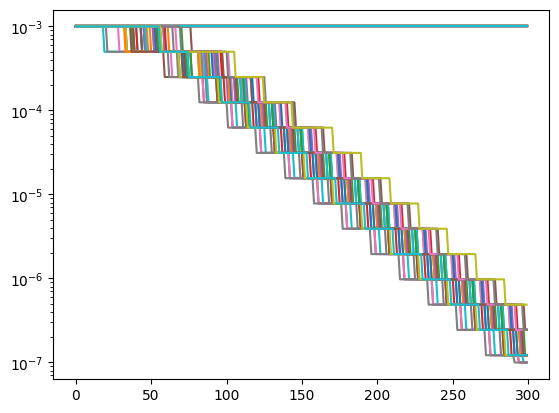

Lstm units=50
mnl_2-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_300
mnl_2-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_None
mnl_4-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_300
mnl_4-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_None
mnl_6-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_300
mnl_6-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-tac_None
1_layer_dynamic_lr
1 layer


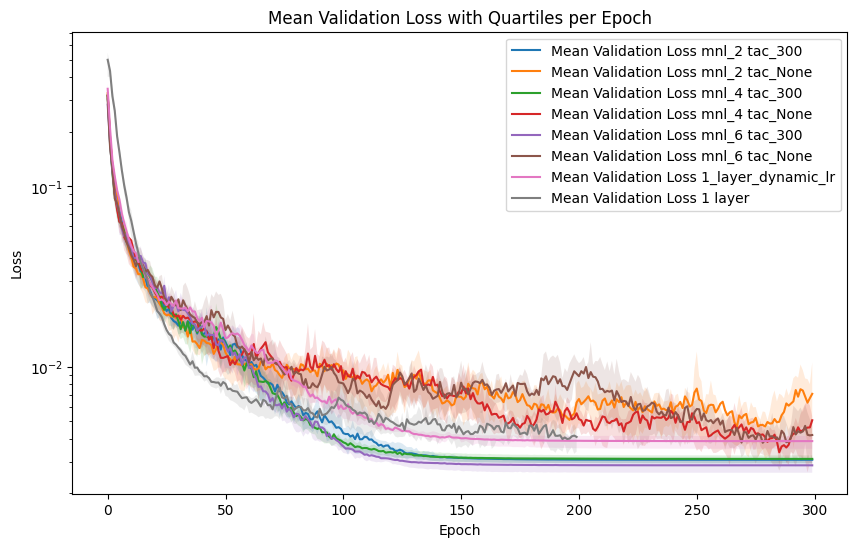

In [68]:

# find the smyl_residual and all other none
all_folds_data = []
experiments_names = []
learning_rates, lr_names = [], []

#exps = static_dilated_results
#for exp in exps:
#    folds_data = get_folds_data(exp, static_dilated_path)
#    all_folds_data.append(folds_data)
#    experiments_names.append(get_train_loss_metric_filename(exp, fold_num=0).replace("_fold0.csv", ""))

exps, path = dyn_no_dil_base_results, dyn_no_dil_base_path
for exp in exps:
    folds_data = get_folds_data(exp, path)
    all_folds_data.append(folds_data)
    experiments_names.append(get_train_loss_metric_filename(exp, fold_num=0).replace("_fold0.csv", ""))
    learning_rates.append(get_learning_rate_data(exp, path))
    lr_names.append(get_exp_name(exp))

exp, path = dynamic_lr_1l_results[0], dynamic_lr_1l_exp_path
dynamic_lr_1l_folds_data = get_folds_data(exp, path)
all_folds_data.append(dynamic_lr_1l_folds_data)
experiments_names.append("1_layer_dynamic_lr")
learning_rates.append(get_learning_rate_data(exp, path))
lr_names.append(get_exp_name(exp))

exp, path = lstm_50, general_single_path
lstm_50_folds_data = get_folds_data(exp, path)
all_folds_data.append(lstm_50_folds_data)
experiments_names.append("1 layer")
#learning_rates.append(get_learning_rate_data(exp, path))
#lr_names.append(get_exp_name(exp))

#exps = dynamic_1l_no_layernorm_results
#for exp in exps:
#    folds_data = get_folds_data(exp, dynamic_1l_no_layernorm_path)
#    all_folds_data.append(folds_data)
#    experiments_names.append(get_train_loss_metric_filename(exp, fold_num=0).replace("_fold0.csv", ""))

#exp = layers_2_results[0]
#layers_2_folds_data = get_folds_data(exp, dynamic_lr_exp_path)
#all_folds_data.append(layers_2_folds_data)
#experiments_names.append("2_layers_dynamic_lr")


#learning_rates.append(get_learning_rate_data(exp, dynamic_lr_exp_path))
#lr_names.append("2_layers_dynamic_lr")

#exps = dynamic_lr_46_results
#for exp in exps:
#    folds_data = get_folds_data(exp, dynamic_lr_46_exp_path)
#    all_folds_data.append(folds_data)
#    experiments_names.append(get_train_loss_metric_filename(exp, fold_num=0).replace("_fold0.csv", ""))
#    learning_rates.append(get_learning_rate_data(exp, dynamic_lr_46_exp_path))
#    lr_names.append(get_exp_name(exp))


for lr_data, name in zip(learning_rates, lr_names):
    for i, fold in enumerate(lr_data):
        plt.plot(fold['epoch'], fold['learning_rate'], label=name + f"_{i}")
#plt.plot([0]['epoch'], layer_2_learning_rate[0]['learning_rate'], label='2_layers_dynamic_lr')
plt.yscale('log')
plt.show()
print(get_exp_name(exp))

plt.figure(figsize=(10, 6))

#for exp in no_bidi_results[::2]:
#    if has_bidi(exp) or has_dilation_base(exp) or has_res_block_size(exp):# or not has_n_layers(exp, 4):
#        continue
#    folds_data = get_folds_data(exp, exp_path)
#    all_folds_data.append(folds_data)
#    #train_loss_filename = get_train_loss_metric_filename(exp, fold_num=0)
#    #experiments_names.append(train_loss_filename.replace("_fold0.csv", ""))
#    experiments_names.append(str(exp["model-num_layers"]) + " layers")

renamed = []
for name in experiments_names:
    print(name)
    name = name.replace("-mrcpu_50-mdb_None-mrbs_2-msr_True-mln_True-mb_True-toplr_0.00-te_300-", " ")
    renamed.append(name)

plot_all_losses(all_folds_data, renamed)#, xlim=(50, 301), ylim=(0.0025, 0.01))